## Importación de librerías

In [21]:
# Data processing  
# -----------------------------------------------------------------------  
import numpy as np  
import pandas as pd  

# Other objectives  
# -----------------------------------------------------------------------  
import math  

# Graphics  
# -----------------------------------------------------------------------  
import seaborn as sns  
import matplotlib.pyplot as plt  

# Path configuration for custom module imports  
# -----------------------------------------------------------------------  
import sys  
sys.path.append('../')  # Adds the parent directory to the path for custom module imports  

# Ignore warnings  
# -----------------------------------------------------------------------  
import warnings  
warnings.filterwarnings("ignore") 

# Curstom functions 
# ----------------------------------------------------------------------- 
from src.support_eda import plot_categoric_distribution, plot_correlation_matrix, plot_numeric_distribution, plot_relation_tv_numeric, plot_outliers  

## Carga de datos

In [22]:
df = pd.read_csv('../data/raw/autorenew.csv', parse_dates=['dateCrawled', 'dateCreated', 'lastSeen'])

In [23]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,offer,480,test,NaN,1993,manually,0.0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,offer,18300,test,coupe,2011,manually,187.0,NaN,125000,5,diesel,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,offer,9800,test,suv,2004,automatic,161.0,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,offer,1500,test,small car,2001,manually,74.0,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,offer,3600,test,small car,2008,manually,68.0,fabia,90000,7,diesel,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


### Selección de columnas

Vamos a eliminar columnas que no nos aporten información relevante:

* `dateCrawled`, `dateCreated`, `lastSeen`: En el EDA preliminar habíamos visto que los anuncios son de entre 2014 y 2016 y que más allá de eso no nos aporta más información.

* `name`: Puede ser útil para identificar el anuncio, aunque en general no nos aporta demasiada información.

* `seller`: Todos los valores son `private` salvo 3 entradas, que son `commercial`. Vamos a eliminar directamente la columna.

* `offerType`: De igual forma, todos los valores son `offer` salvo 12 entradas, que son `request`. Podemos eliminar la columna y los vehículos que son `request`.

* `model`: Tenemos más de 250 entradas y es una subcategoría de `brand`. Podríamos dejarla para un análisis más granular pero ahora vamos a eliminarla.

* `monthOfRegistration`: Podríamos hacer un análisis de estacionalidad o por temporadas, pero no será el caso. Además, hay un valor que es 0, lo cual es imposible para meses por lo que realmente sería desconocido. Utilizaremos solamente `yearOfRegistration`.

* `nrOfPictures`: Todos los valores son 0 por lo que no aporta valor.

In [24]:
columnas_eliminar = [
    'dateCrawled',
    'dateCreated', 
    'lastSeen', 
    'name', 
    'seller', 
    'offerType', 
    'model', 
    'monthOfRegistration', 
    'nrOfPictures'
    ]

In [26]:
df.drop(columns=columnas_eliminar, inplace=True)

## Limpieza de datos

Vayamos columna a columna

In [27]:
df.columns.to_list()

['price',
 'abtest',
 'vehicleType',
 'yearOfRegistration',
 'gearbox',
 'powerCV',
 'kilometer',
 'fuelType',
 'brand',
 'notRepairedDamage',
 'postalCode']

### Columna `price`

Valores de precio extremadamente bajos no tienen sentido. Sin embargo, es difícil establecer un criterio estricto para filtrar ya que vehículos muy antiguos o con daños realmente pueden tener precios muy bajos.

In [43]:
print(f"El porcentaje de valores nulos en la columna price es: {df['price'].isna().sum()}")

El porcentaje de valores nulos en la columna price es: 0


Como no teníamos valores nulos, veamos qué proporción de vehículos tienen un valor inferior a cierto umbral. Podemos elegir el umbral por ejemplo en 100 (presumiblemente euros).

In [50]:
umbral_precio_inferior = 100
porcentaje_baratos = (df['price'] < umbral_precio_inferior).mean() * 100

print(f"El porcentaje de vehículos por debajo de {umbral_precio_inferior} es: {porcentaje_baratos:.2f}")

El porcentaje de vehículos por debajo de 100 es: 3.59


Los datos con un precio inferior a 100 son muy probablemente erróneos y representan alrededor del 3,6 % del conjunto de datos, por lo que parece razonable eliminarlos.  

Es posible que haya vehículos que realmente tengan un precio por debajo de 100 debido a daños no reparados o a su antigüedad, pero es difícil establecer este criterio, así que procederemos de esta manera.

Veamos ahora qué sucede con los vehículos con un precio muy elevado. Pongamos el umbral en 4M.

In [51]:
umbral_precio_superior = 4e6
porcentaje_caros = (df['price'] > umbral_precio_superior).mean() * 100

print(f"El porcentaje de vehículos por encima de {umbral_precio_superior} es: {porcentaje_caros:.2f}")

El porcentaje de vehículos por encima de 4000000.0 es: 0.01


Podemos revisar manualmente estos datos para comprobar si tienen sentido:

In [54]:
df[df['price'] > umbral_precio_superior].sample(5)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,kilometer,fuelType,brand,notRepairedDamage,postalCode
287835,12345678,test,combi,2001,manually,100.0,150000,petrol,ford,no,17291
310924,12345678,test,small car,1997,manually,44.0,150000,petrol,volkswagen,NaN,18276
273145,12345678,control,NaN,2017,NaN,94.0,150000,NaN,fiat,NaN,96110
358868,10000000,control,combi,2002,manually,0.0,150000,diesel,bmw,no,25821
77520,99999999,control,NaN,1999,automatic,221.0,150000,petrol,mercedes_benz,NaN,73525


Tras revisar los datos, podemos concluir que todos los precios superiores a 4 millones corresponden a registros erróneos.

Por lo tanto, filtramos los datos por precios de esta forma:

In [55]:
filtro_precio = (df['price'] > umbral_precio_inferior) & (df['price'] < umbral_precio_superior)

df = df[filtro_precio]

### Columna `yearOfRegistration`

Tal y como vimos con las columnas de fechas de los anuncios, los registros no pueden ser de después de 2016. Sin embargo, vamos a comprobar las entradas posteriores a este año

In [59]:
df[df['yearOfRegistration'] > 2016]['yearOfRegistration'].value_counts().head()

yearOfRegistration
2017    9925
2018    3797
2019      15
9999      14
5000      14
Name: count, dtype: int64

Vemos que hay unas cuantas entradas en 2017 y 2018, por lo que vamos a mantenerlas ya que es posible que las columnas de fechas que habíamos eliminado posiblemente fuesen las que estaban mal.

El resto de años son mucho menos frecuentes y la mayoría no tienen sentido por lo que podemos asumir que son errores y eliminarlos o etiquetarlos como nulos.

Veamos ahora qué ocurre con vehículos con fechas de registro muy antiguas. Por ejemplo, establezcamos el umbral en 1930.

In [62]:
umbral_fecha = 1930

df[df['yearOfRegistration'] < umbral_fecha]['yearOfRegistration'].value_counts().head()

yearOfRegistration
1910    36
1000    23
1929     7
1800     4
1234     3
Name: count, dtype: int64

Vemos que tenemos 36 entradas de 1910, que seguramente sean errores (por la fecha de invención del coche). Veamos la distribución de forma gráfica más detallada.

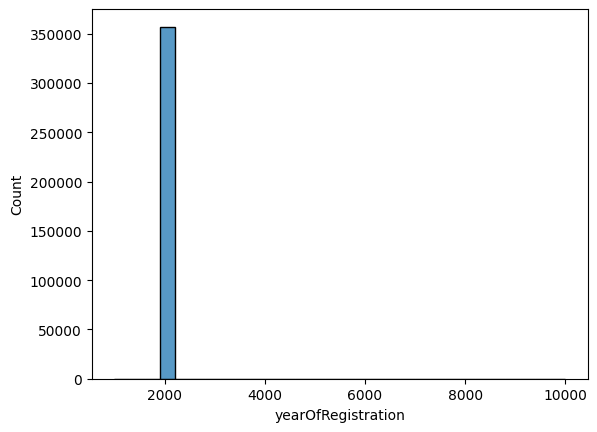

In [65]:
plt.figure()

sns.histplot(df['yearOfRegistration'], bins=30)
plt.show()